In [177]:
import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
import matplotlib.pyplot as plt
import wordninja
import regex as re
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords
from nltk.corpus import stopwords

In [165]:
l_data = pd.read_csv('../data/liberal_results_df.csv')
c_data = pd.read_csv('../data/conservative_results.csv')               


In [166]:
l_data.drop(l_data.index[[1741]], inplace=True)# during eda it was discovered that this cell contained unusable data.


In [167]:
l_data['selftext'] = l_data['selftext'].fillna('[removed]')
c_data['selftext'] = c_data['selftext'].fillna('[removed]')# fill empty columns with removed 


In [168]:
l_data['selftext'] = l_data['selftext'].apply(lambda x : x.replace('[removed]',''))
c_data['selftext'] = c_data['selftext'].apply(lambda x : x.replace('[removed]',''))#remove empty columns


In [169]:
l_data['fulltext'] = l_data['title'] + ' ' + l_data['selftext']
c_data['fulltext'] = c_data['title'] + ' ' + c_data['selftext']# combine text from title and selftext


In [170]:
c_categorical_nums = {"subreddit": {'Conservative': 1}}#make classification categories
l_categorical_nums = {"subreddit": {'Liberal': 0}}
c_data.replace(c_categorical_nums, inplace=True)
l_data.replace(l_categorical_nums, inplace=True)

In [174]:
def get_len(post):
    return len(post.split())
l_data['post_len'] = l_data['fulltext'].map(get_len)# create a column that has the length of the posts
c_data['post_len'] = c_data['fulltext'].map(get_len)
#courtesy of markel jones-francis

In [298]:
l_data['author'] = l_data['author'].apply(lambda x : x.replace('[deleted]',' '))
c_data['author'] = c_data['author'].apply(lambda x : x.replace('[deleted]',' '))# delete empty author entries


In [139]:
def remove_links_lower_and_nums(data,col):
    string = []
    letters = []
    remove_links = []
    lower = []
    for i in data[col]:
        string.append(str(i))
    for j in string:
        letters.append(re.sub(r'[^A-Za-z0-9 ]+', "", j))#remove letters and number
    for k in letters:
        remove_links.append(re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b','',k))#remove links
    return lower
    l_data['fulltext'] = remove_links_lower_and_nums(l_data,'fulltext')
    c_data['fulltext'] = remove_links_lower_and_nums(c_data,'fulltext')



In [140]:
def make_str_remove_non_letters_lower(data,col):
    string = []
    for i in data[col]:
        string.append(str(i))
    long_words = []
    for i in string:
        long_words.append(re.sub(r'/.{20,}/','',i))#remove words longer than 20 chars
    lower = []
    for i in long_words:
        lower.append(i.lower())
    return lower
l_data['fulltext'] = make_str_remove_non_letters_lower(l_data,'fulltext')
c_data['fulltext'] = make_str_remove_non_letters_lower(c_data,'fulltext')

    


In [141]:
def remove_nums(data,col):# during eda we discovered that a lot of numeric columns has corrupted or non valuble data
    data[col] = data[col].str.replace(r'\d+','')
remove_nums(c_data,'fulltext')
remove_nums(l_data,'fulltext')

In [142]:
def remove_underscores(data,col):# during eda we discovered that underscores were corrupting the values
    data[col] = data[col].str.replace('_',' ')
remove_underscores(c_data,'fulltext')
remove_underscores(l_data,'fulltext')

In [148]:
def remove_link_words(data,col): # during eda we discovered that underscores were corrupting the values
    data[col] = data[col].str.replace('https','')
    data[col] = data[col].str.replace('http','')
remove_link_words(c_data,'fulltext')
remove_link_words(l_data,'fulltext')

In [149]:
cvec = CountVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = 'english',
                       
                             max_features = 50000)

In [150]:
l_data = cvec.fit_transform(l_data['fulltext'])
l_df = pd.DataFrame(l_data.toarray(),
                          columns=cvec.get_feature_names())


In [151]:
c_data = cvec.fit_transform(c_data['fulltext'])
c_df = pd.DataFrame(c_data.toarray(),
                          columns=cvec.get_feature_names())

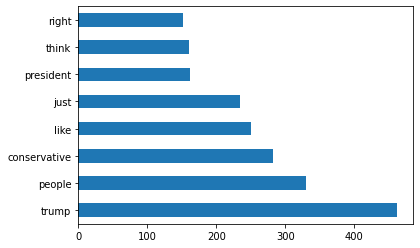

In [289]:
c_df.sum()[c_df.sum()>=150].sort_values(ascending=False).plot(kind='barh');

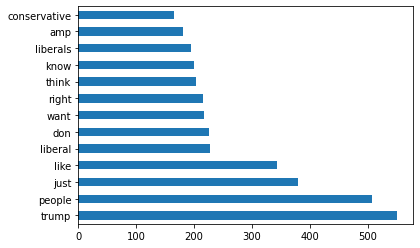

In [290]:
l_df.sum()[l_df.sum()>=150].sort_values(ascending=False).plot(kind='barh');

Text(12, 0, 'Average Length of a Post 61.5 Char')

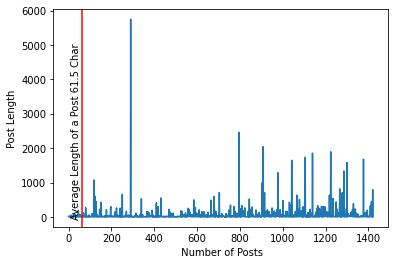

In [288]:
(c_data['post_len'].plot()) 
plt.xlabel(' Number of Posts')
plt.ylabel('Post Length')
plt.axvline(x=(c_data['post_len'].mean()),color = 'r')
plt.text(12,0, 'Average Length of a Post 61.5 Char',rotation=90)

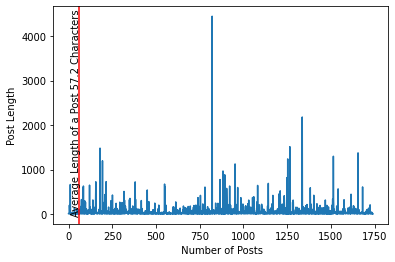

<Figure size 720x1296 with 0 Axes>

In [286]:
(l_data['post_len'].plot()) 
plt.xlabel(' Number of Posts')
plt.ylabel('Post Length')
plt.axvline(x=(l_data['post_len'].mean()),color = 'r')
plt.text(12,0, 'Average Length of a Post 57.2 Characters',rotation=90)
plt.figure(figsize=(10,18))
plt.show()

In [262]:
from better_profanity import profanity
def profanity_counter(data,col):
    counter = 0
    for i in data[col]:
        if profanity.contains_profanity(i) == True:
            counter += 1
    return counter
l_swear = profanity_counter(l_data,'fulltext')
c_swear = profanity_counter(c_data,'fulltext')   

l_swear

156

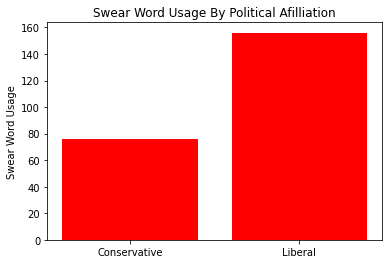

In [268]:
x = ['Conservative', 'Liberal']
y = [76,156]
plt.bar(x,y,color = 'r');
plt.ylabel('Swear Word Usage')
plt.title('Swear Word Usage By Political Afilliation');

In [341]:
def get_prolific_authors(dat,col):
    prolific_authors = []
    
    for i in c_data['author']:
        for j in l_data['author']:
            if i==j:
                prolific_authors.append(i)
    authors = set(prolific_authors)
for i in authors:
    l_authors_df = l_data[l_data['author'] == i]
l_authors_df
for i in authors:
    c_authors_df = c_data[c_data['author'] == i]

authors

{'',
 '6E1DE647E76DF71D',
 'AlbertMendez442',
 'BlightBorn',
 'Careless_Mix',
 'Diylion',
 'Teroaego',
 'chrcke23',
 'jorge921995',
 'mayatalluluh',
 'megafatdingus',
 'outofTheirclosetToo',
 'puncakeking89',
 'sgar589',
 'sparklepig7',
 'xxNarutozumaki6699xx'}

In [ ]:
X = full_df['fulltext']
y = full_df['subreddit']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)